In [36]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score, precision_score, recall_score, f1_score

import polars as pl
import numpy as np

from adex.models import Condition, ConditionDataLoader, ConditionSequencingTissueDataLoader, \
    ConditionSequencingDataLoader, SequencingTechnique, TissueEnum, METADATA_COLUMNS, FileDataLoader, DataLoader
from adex.helpers import get_pre_processed_dataset
from adex.models import DATASET_INFO_COLUMNS
from sklearn import model_selection

data_path = "../data/adex-database/samples"
metadata_path = "../data/adex-database/metadata.csv"
datasets_info_path = "../data/adex-database/datasets_info.csv"
results_path = "../results"

# POC: Try running simple Logistic Regression task with all Differentially expressed genes of the GSE89408 dataset

## Prepare Data

In [37]:
de_genes_ra_GSE89408_synovial = (
    pl
    .read_csv(f"{results_path}/RA_GSE89408/edgeR_de_genes.csv", has_header=True)
    .to_series()
    .to_list()
)
len(de_genes_ra_GSE89408_synovial)

148

In [38]:
de_GSE89408 = (
    get_pre_processed_dataset(
        data_loader=FileDataLoader(
            condition=Condition.RA,
            file_name="GSE89408.tsv.parquet",
            genes=de_genes_ra_GSE89408_synovial
        ),
        data_path=data_path,
        metadata_path=metadata_path,
        datasets_info_path=datasets_info_path,
        return_metadata=True
    ).fill_null(value=0)
    .drop(filter(lambda item: item != 'Condition',METADATA_COLUMNS)) # We need only the condition from Metadata  
    .drop(DATASET_INFO_COLUMNS)
    .with_columns(
        pl.col("Condition")
            .map_elements(lambda x: 0 if x == "Healthy" else 1, return_dtype=pl.Int8)
            .alias("class_label")
    )
    .drop("Condition")
).sort("Sample")  # Remove randomness at this point 
de_GSE89408

Sample,B3GALNT1P1,AC068631.2,AC090204.1,AD000671.1,C12orf74,AC022973.3,LINC02605,SERPINI2,AL139099.1,HSPE1P13,NTN3,AC022079.1,AC055811.2,AC084876.1,AC005306.1,TCTEX1D1,HIST1H2BO,GPR19,XCL1,AC037198.2,FOXI2,TNFRSF10A-AS1,TRGC1,AC090229.1,AC017083.2,AC006486.1,AC015911.3,HSPE1-MOB4,AC132217.1,STEAP1B,DM1-AS,AL513475.2,RPL21P28,RPL9P30,AC025423.4,AC022973.1,…,RBM43P1,STYK1,AC112496.1,KIF14,AC023825.1,RPS3AP47,CDC25C,AC099560.2,Z86062.1,RNVU1-15,NME8,AC090617.3,AC133065.1,NUP62CL,PLCH1,MELK,AP000462.2,LINC02577,AL139011.2,AC008833.1,AC124068.1,AL157402.2,MOXD1,AL512504.1,AL359697.1,TRGV10,AC084824.5,AL136962.1,HIST1H2AK,CENPA,AL136295.1,CCER2,AC073896.1,AL359885.1,AC130895.1,HORMAD1,class_label
str,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,…,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,i8
"""GSM2370970""",0.0,5.322358,2.554955,0.0,0.0,1.149989,4.798087,3.05567,0.0,2.219515,6.912578,1.149989,6.774812,0.0,6.431933,3.581605,3.25306,3.05567,0.0,3.721507,5.488271,1.149989,0.0,0.0,0.0,0.0,3.05567,0.0,0.0,3.721507,6.622488,3.25306,3.849033,0.0,0.0,3.05567,…,4.175342,1.781672,1.781672,5.083907,1.149989,3.581605,1.149989,1.149989,0.0,2.219515,1.781672,0.0,2.554955,3.05567,3.849033,4.175342,2.554955,1.781672,8.839742,3.721507,0.0,1.781672,1.149989,0.0,2.826927,2.554955,0.0,2.554955,1.781672,1.781672,0.0,5.771922,8.464858,3.426665,1.149989,2.826927,0
"""GSM2370971""",5.274107,1.326442,5.157051,5.827561,2.813799,4.13637,4.466606,3.864979,7.078922,4.255048,2.813799,3.707378,0.0,3.530425,0.0,4.466606,1.326442,2.813799,1.326442,4.735153,3.094096,3.530425,2.465583,4.007047,7.938222,4.007047,0.0,6.562024,7.718286,6.515227,4.364701,3.864979,5.748842,4.735153,7.707919,2.465583,…,1.326442,4.96147,3.094096,4.466606,3.094096,4.889904,0.0,4.735153,3.530425,3.094096,1.326442,5.707811,1.326442,3.094096,5.382374,3.094096,5.48308,0.0,2.00564,7.577331,5.329256,2.465583,5.274107,2.465583,3.864979,1.326442,4.651071,3.094096,2.00564,1.326442,0.0,4.007047,3.530425,4.735153,5.865367,4.364701,0
"""GSM2370972""",4.110154,2.341239,3.427834,3.056805,3.808962,3.056805,2.556025,2.088786,0.0,4.958777,3.890357,3.427834,4.958777,5.590409,1.393389,3.630947,1.393389,2.742939,1.782587,3.630947,3.314439,2.088786,3.630947,3.890357,7.53651,2.341239,4.469258,0.0,6.587614,1.782587,3.808962,4.469258,2.556025,2.742939,6.148911,4.30085,…,3.056805,1.782587,3.722698,3.056805,2.90839,4.666998,0.858757,2.742939,3.427834,3.532962,2.088786,2.742939,3.056805,3.630947,3.427834,1.393389,2.90839,2.088786,5.489532,3.056805,4.620045,2.90839,2.088786,3.722698,4.110154,0.858757,3.532962,2.088786,3.427834,2.341239,0.0,2.742939,5.381067,4.996029,5.323615,3.427834,0
"""GSM2370973""",3.290575,0.0,4.450513,0.0,3.933163,3.11884,4.937789,3.709225,3.11884,3.290575,4.773736,3.933163,3.709225,4.588606,4.773736,2.430957,2.69836,2.69836,0.0,4.521211,3.11884,3.58271,0.0,4.830519,0.0,0.0,1.676383,0.0,0.0,1.069102,4.714627,2.69836,0.0,2.69836,5.776321,3.933163,…,4.033316,2.102451,2.102451,4.376172,3.290575,1.069102,1.676383,2.430957,2.923865,0.0,2.69836,0.0,3.11884,3.709225,3.11884,3.825534,3.58271,2.923865,6.362144,3.290575,0.0,1.676383,5.175528,2.923865,2.430957,0.0,2.69836,3.11884,3.11884,1.676383,0.0,3.58271,7.353349,4.652992,3.58271,3.709225,0
"""GSM2370974""",3.860753,1.963042,3.277464,4.596378,3.539662,3.277464,2.765039,4.123229,0.0,4.123229,4.201084,3.860753,6.360493,4.810225,5.905518,3.654817,3.414511,1.552158,0.0,2.765039,4.476259,3.761456,4.537568,3.277464,5.758763,3.953653,4.040931,0.0,5.475165,1.963042,4.652884,3.761456,1.552158,4.274953,4.476259,2.956789,…,1.552158,2.543839,1.963042,2.765039,3.414511,3.277464,1.963042,2.282472,3.761456,1.963042,0.975467,3.414511,2.282472,1.963042,2.543839,3.654817,3.761456,0.0,6.758314,3.277464,0.0,1.552158,1.552158,3.126018,1.552158,0.0,4.040931,1.963042,2.543839,1.

In [39]:
de_GSE89408.select(pl.col("class_label").value_counts()) # Imbalanced data between the two classes

class_label
struct[2]
"{0,28}"
"{1,152}"


In [40]:
x_df = (
        de_GSE89408.select([
            pl.all().exclude("Sample", "class_label"),
        ]).to_pandas()
 )
x_df

,B3GALNT1P1,AC068631.2,AC090204.1,AD000671.1,C12orf74,AC022973.3,LINC02605,SERPINI2,AL139099.1,HSPE1P13,...,AC084824.5,AL136962.1,HIST1H2AK,CENPA,AL136295.1,CCER2,AC073896.1,AL359885.1,AC130895.1,HORMAD1
0,0.000000,5.322358,2.554955,0.000000,0.000000,1.149989,4.798087,3.055670,0.000000,2.219515,...,0.000000,2.554955,1.781672,1.781672,0.000000,5.771922,8.464858,3.426665,1.149989,2.826927
1,5.274107,1.326442,5.157051,5.827561,2.813799,4.136370,4.466606,3.864979,7.078922,4.255048,...,4.651071,3.094096,2.005640,1.326442,0.000000,4.007047,3.530425,4.735153,5.865367,4.364701
2,4.110154,2.341239,3.427834,3.056805,3.808962,3.056805,2.556025,2.088786,0.000000,4.958777,...,3.532962,2.088786,3.427834,2.341239,0.000000,2.742939,5.381067,4.996029,5.323615,3.427834
3,3.290575,0.000000,4.450513,0.000000,3.933163,3.118840,4.937789,3.709225,3.118840,3.290575,...,2.698360,3.118840,3.118840,1.676383,0.000000,3.582710,7.353349,4.652992,3.582710,3.709225
4,3.860753,1.963042,3.277464,4.596378,3.539662,3.277464,2.765039,4.123229,0.000000,4.123229,...,4.040931,1.963042,2.543839,1.552158,5.161323,3.539662,5.706329,4.201084,5.039452,2.956789
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
175,4.024164,6.175148,5.574679,5.522382,4.899359,4.024164,5.649734,5.625147,8.181333,3.588386,...,3.778756,2.606461,6.069768,4.473051,7.223622,2.961026,4.297458,5.697685,5.017425,4.527134
176,4.556913,7.609490,6.447343,0.000000,3.747892,4.968532,4.895071,6.240470,10.372098,3.829024,...,4.649168,3.829024,4.735877,4.406426,9.765952,0.000000,0.000000,5.708549,4.856889,5.501395
177,4.090675,5.154133,5.345988,5.375623,3.680031,4.017369,5.084059,3.476277,9.312345,4.351508,...,3.476277,2.129744,5.433126,3.581748,8.656909,2.384187,4.160436,4.763788,4.932793,3.772043
178,3.602317,6.608690,4.541667,4.975613,4.586973,3.309785,4.586973,4.941135,10.422702,3.768847,...,4.494892,3.309785,4.446549,3.845417,9.907240,0.000000,3.075558,5.074363,4.586973,3.197420


In [41]:
y_df = de_GSE89408.select(pl.col("class_label").alias("y")).to_pandas()
y_df

,y
0,0
1,0
2,0
3,0
4,0
...,...
175,1
176,1
177,1
178,1


In [42]:
x_train, x_test, y_train, y_test = model_selection.train_test_split(
    x_df, y_df, 
    train_size=0.7, 
    random_state=42,  # Ensure a reproducible split 
    shuffle=True, 
    stratify=y_df  # solve the class imbalance issue 
)

In [43]:
x_train

,B3GALNT1P1,AC068631.2,AC090204.1,AD000671.1,C12orf74,AC022973.3,LINC02605,SERPINI2,AL139099.1,HSPE1P13,...,AC084824.5,AL136962.1,HIST1H2AK,CENPA,AL136295.1,CCER2,AC073896.1,AL359885.1,AC130895.1,HORMAD1
13,3.915082,3.828335,1.864341,0.000000,2.433411,1.465022,5.312334,1.864341,0.000000,3.293280,...,2.433411,0.910992,1.864341,2.433411,5.374885,3.736035,6.559429,2.840437,3.996909,1.864341
73,5.021448,7.227001,4.792319,0.000000,4.841148,4.689403,7.051379,5.577186,10.635017,4.327569,...,4.635054,2.749214,5.740535,4.689403,8.482869,2.749214,0.000000,5.488007,5.714563,5.103796
4,3.860753,1.963042,3.277464,4.596378,3.539662,3.277464,2.765039,4.123229,0.000000,4.123229,...,4.040931,1.963042,2.543839,1.552158,5.161323,3.539662,5.706329,4.201084,5.039452,2.956789
5,5.320277,0.000000,3.491997,4.619271,4.789359,4.033571,7.195406,7.185280,7.339339,5.204724,...,4.281848,3.840610,0.000000,3.201774,7.763535,2.838079,4.426415,5.494410,5.244279,5.079104
57,5.575271,0.000000,4.196747,0.000000,5.209813,4.719174,7.126211,6.022732,9.256971,4.298032,...,4.481480,4.858338,5.899217,4.858338,0.000000,2.663277,6.316270,5.764129,4.644211,4.087811
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
53,5.374506,6.967549,5.657676,5.435761,3.321436,4.981323,6.576888,5.310534,6.324991,4.660541,...,4.554066,5.523027,5.277452,4.103822,7.249282,0.925741,4.981323,5.374506,5.999462,4.806828
64,5.303640,5.483675,4.569717,5.426124,5.022228,5.022228,5.303640,4.139415,9.004779,4.515562,...,4.139415,4.139415,5.169785,3.906756,7.378151,1.857876,0.000000,4.768045,5.668743,4.813642
176,4.556913,7.609490,6.447343,0.000000,3.747892,4.968532,4.895071,6.240470,10.372098,3.829024,...,4.649168,3.829024,4.735877,4.406426,9.765952,0.000000,0.000000,5.708549,4.856889,5.501395
89,5.121104,6.887744,4.743966,5.449477,4.791080,5.449477,6.225564,4.836703,9.491333,5.006009,...,4.231939,5.478550,4.161974,4.362446,6.843731,1.474597,3.170850,5.358567,5.833912,5.615729


In [44]:
y_train

,y
13,0
73,1
4,0
5,0
57,1
...,...
53,1
64,1
176,1
89,1


In [45]:
y_train.value_counts()

y
1    106
0     19
Name: count, dtype: int64

In [46]:
x_test

,B3GALNT1P1,AC068631.2,AC090204.1,AD000671.1,C12orf74,AC022973.3,LINC02605,SERPINI2,AL139099.1,HSPE1P13,...,AC084824.5,AL136962.1,HIST1H2AK,CENPA,AL136295.1,CCER2,AC073896.1,AL359885.1,AC130895.1,HORMAD1
18,4.951320,5.692894,4.697582,5.966702,3.997214,3.997214,5.026866,5.927814,8.564358,5.063206,...,4.445625,0.873119,3.997214,4.140154,7.827820,2.936015,3.219739,5.782807,5.494280,5.383680
98,5.654548,4.946210,3.845145,0.000000,4.208353,6.040030,3.622275,5.712296,7.929231,4.286473,...,3.622275,5.325031,4.682909,2.618922,6.288057,0.000000,2.842273,5.897946,6.084443,6.684112
166,4.260884,6.334043,3.904773,5.167719,5.275775,4.784410,6.028985,4.457266,8.646634,5.558494,...,3.904773,6.089465,4.546265,4.630091,8.757958,2.998015,0.000000,5.326911,4.784410,3.904773
140,4.634278,4.693256,3.632169,0.000000,4.441332,3.506254,5.219943,4.907660,9.799556,3.506254,...,5.137399,5.635332,4.956628,3.632169,9.647547,2.627941,5.137399,4.296689,4.956628,4.218538
29,5.411487,5.856029,5.763080,6.159354,3.770749,5.027822,5.179399,6.854827,6.973673,4.253259,...,4.253259,5.471475,6.159354,5.786885,7.882120,1.891634,6.773760,5.943351,5.900351,6.065158
90,5.822151,5.682767,3.978444,5.682767,3.619311,4.559386,4.931939,6.138970,8.490438,4.710583,...,4.390467,5.444645,5.324730,5.227763,7.532159,1.850073,0.000000,5.633144,6.138970,5.193937
162,4.838643,6.923948,5.457953,5.241020,2.671150,4.985595,5.211458,5.269989,9.872784,2.982486,...,3.553204,2.024394,5.668414,4.440315,9.252759,2.982486,4.334590,5.406701,4.096607,5.578642
105,5.171047,3.460481,5.210576,3.586021,4.460533,4.249021,6.871509,5.701572,8.922993,5.001118,...,4.460533,3.170951,4.249021,3.907968,0.000000,2.322852,4.701550,5.171047,5.249051,5.088583
74,3.311224,6.345800,1.477789,6.645003,0.920376,3.025182,4.486882,4.486882,0.000000,1.477789,...,3.311224,4.700053,6.935398,5.197878,9.560818,3.175281,6.377123,3.311224,0.920376,4.166680
45,5.653539,5.871831,6.378994,3.737057,3.737057,4.681919,6.578365,6.578365,9.390506,4.896259,...,3.737057,3.737057,5.396225,5.082836,8.503040,2.353716,0.000000,5.248023,5.653539,6.061393


In [47]:
y_test

,y
18,0
98,1
166,1
140,1
29,1
90,1
162,1
105,1
74,1
45,1


In [48]:
y_test.value_counts()

y
1    46
0     9
Name: count, dtype: int64

# Logistic Regression 

In [49]:
logistic_model = LogisticRegression(solver='liblinear', random_state=0).fit(x_train, np.ravel(y_train))
logistic_model.intercept_

array([-0.01246653])

In [50]:
logistic_model.coef_

array([[-0.02754751,  0.37274296,  0.00307894, -0.09535901,  0.02469013,
         0.03418109, -0.03054599,  0.00800528,  0.03009996, -0.0181071 ,
        -0.05708879,  0.07478593, -0.18848215,  0.04463643, -0.03562092,
         0.13412721,  0.13414414, -0.02049699,  0.01824495, -0.09187374,
        -0.10821048,  0.09223414,  0.02101867,  0.10033213, -0.02082379,
         0.02040034,  0.08096495,  0.14778642, -0.01912503,  0.11044165,
        -0.10333115,  0.0389311 ,  0.14814034, -0.0296425 , -0.03226545,
         0.0419338 , -0.03868581, -0.0316495 ,  0.20970064, -0.03182752,
         0.07096044, -0.01937324,  0.04455961, -0.132613  , -0.246424  ,
        -0.02569146, -0.11386969, -0.26010725,  0.05959803, -0.04435806,
        -0.14507141, -0.06503798, -0.209411  ,  0.15796335, -0.03367845,
        -0.07863108,  0.023773  ,  0.02177798, -0.11001302,  0.10256653,
        -0.03612088, -0.05181576, -0.19646046, -0.04229357,  0.04487715,
         0.0101564 , -0.07476414, -0.02992095, -0.0

In [51]:
logistic_model.predict_proba(x_test)

array([[1.59013386e-02, 9.84098661e-01],
       [3.23116074e-05, 9.99967688e-01],
       [2.71296126e-04, 9.99728704e-01],
       [3.74995875e-04, 9.99625004e-01],
       [8.26887416e-05, 9.99917311e-01],
       [1.92139864e-04, 9.99807860e-01],
       [4.81026791e-05, 9.99951897e-01],
       [2.72171313e-04, 9.99727829e-01],
       [5.48135186e-03, 9.94518648e-01],
       [4.44172770e-05, 9.99955583e-01],
       [6.16900765e-07, 9.99999383e-01],
       [8.51898858e-04, 9.99148101e-01],
       [3.93986781e-05, 9.99960601e-01],
       [5.28749763e-08, 9.99999947e-01],
       [3.95867578e-01, 6.04132422e-01],
       [1.57891885e-06, 9.99998421e-01],
       [3.58292234e-03, 9.96417078e-01],
       [9.71771579e-01, 2.82284206e-02],
       [1.95604242e-07, 9.99999804e-01],
       [7.82890841e-06, 9.99992171e-01],
       [3.30837891e-06, 9.99996692e-01],
       [2.04941253e-06, 9.99997951e-01],
       [7.90512674e-05, 9.99920949e-01],
       [2.72796449e-07, 9.99999727e-01],
       [4.468431

In [52]:
logistic_prediction = logistic_model.predict(x_test)
logistic_prediction

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1,
       1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0,
       0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1], dtype=int8)

In [53]:
logistic_model.score(x_test, y_test)

0.9636363636363636

In [54]:
cm = confusion_matrix(y_test, logistic_prediction)
# Rows: Predictions
# Columns: Facts
# TN FP 
# FN TP 

# TN (Healthy predicted Healthy): 7
# FP (Healthy predicted Diseased): 2
# FN (Diseased predicted Healthy): 0
# TP (Diseased predicted Diseased): 46
cm 

array([[ 7,  2],
       [ 0, 46]])

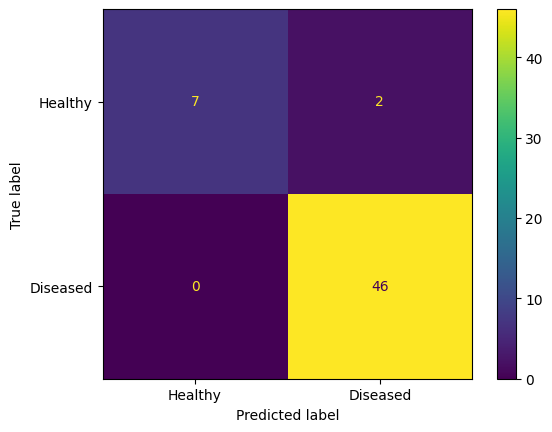

In [55]:
ConfusionMatrixDisplay(confusion_matrix = cm, display_labels = ["Healthy", "Diseased"]).plot()

In [56]:
accuracy = accuracy_score(y_test, logistic_prediction)
precision = precision_score(y_test, logistic_prediction)
recall = recall_score(y_test, logistic_prediction)
f1 = f1_score(y_test, logistic_prediction)

print(f""""
Accuracy: {accuracy}
Precision: {precision}
Recall: {recall}
f1: {f1}
""")
accuracy

"
Accuracy: 0.9636363636363636
Precision: 0.9583333333333334
Recall: 1.0
f1: 0.9787234042553191



0.9636363636363636

# Keep Test Set Sample IDs  


In [57]:
x_df_to_split = de_GSE89408.to_pandas()
x_df_to_split

,Sample,B3GALNT1P1,AC068631.2,AC090204.1,AD000671.1,C12orf74,AC022973.3,LINC02605,SERPINI2,AL139099.1,...,AL136962.1,HIST1H2AK,CENPA,AL136295.1,CCER2,AC073896.1,AL359885.1,AC130895.1,HORMAD1,class_label
0,GSM2370970,0.000000,5.322358,2.554955,0.000000,0.000000,1.149989,4.798087,3.055670,0.000000,...,2.554955,1.781672,1.781672,0.000000,5.771922,8.464858,3.426665,1.149989,2.826927,0
1,GSM2370971,5.274107,1.326442,5.157051,5.827561,2.813799,4.136370,4.466606,3.864979,7.078922,...,3.094096,2.005640,1.326442,0.000000,4.007047,3.530425,4.735153,5.865367,4.364701,0
2,GSM2370972,4.110154,2.341239,3.427834,3.056805,3.808962,3.056805,2.556025,2.088786,0.000000,...,2.088786,3.427834,2.341239,0.000000,2.742939,5.381067,4.996029,5.323615,3.427834,0
3,GSM2370973,3.290575,0.000000,4.450513,0.000000,3.933163,3.118840,4.937789,3.709225,3.118840,...,3.118840,3.118840,1.676383,0.000000,3.582710,7.353349,4.652992,3.582710,3.709225,0
4,GSM2370974,3.860753,1.963042,3.277464,4.596378,3.539662,3.277464,2.765039,4.123229,0.000000,...,1.963042,2.543839,1.552158,5.161323,3.539662,5.706329,4.201084,5.039452,2.956789,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
175,GSM2371183,4.024164,6.175148,5.574679,5.522382,4.899359,4.024164,5.649734,5.625147,8.181333,...,2.606461,6.069768,4.473051,7.223622,2.961026,4.297458,5.697685,5.017425,4.527134,1
176,GSM2371184,4.556913,7.609490,6.447343,0.000000,3.747892,4.968532,4.895071,6.240470,10.372098,...,3.829024,4.735877,4.406426,9.765952,0.000000,0.000000,5.708549,4.856889,5.501395,1
177,GSM2371185,4.090675,5.154133,5.345988,5.375623,3.680031,4.017369,5.084059,3.476277,9.312345,...,2.129744,5.433126,3.581748,8.656909,2.384187,4.160436,4.763788,4.932793,3.772043,1
178,GSM2371186,3.602317,6.608690,4.541667,4.975613,4.586973,3.309785,4.586973,4.941135,10.422702,...,3.309785,4.446549,3.845417,9.907240,0.000000,3.075558,5.074363,4.586973,3.197420,1


In [58]:
y_df_to_split = de_GSE89408.select(pl.col("class_label").alias("y")).to_pandas()
y_df_to_split

,y
0,0
1,0
2,0
3,0
4,0
...,...
175,1
176,1
177,1
178,1


In [59]:
x_train, x_test, y_train, y_test = model_selection.train_test_split(
    x_df_to_split, y_df_to_split,
    train_size=0.7,
    random_state=42,  # Ensure a reproducible split 
    shuffle=True,
    stratify=y_df  # solve the class imbalance issue 
)

In [60]:
x_train

,Sample,B3GALNT1P1,AC068631.2,AC090204.1,AD000671.1,C12orf74,AC022973.3,LINC02605,SERPINI2,AL139099.1,...,AL136962.1,HIST1H2AK,CENPA,AL136295.1,CCER2,AC073896.1,AL359885.1,AC130895.1,HORMAD1,class_label
13,GSM2370983,3.915082,3.828335,1.864341,0.000000,2.433411,1.465022,5.312334,1.864341,0.000000,...,0.910992,1.864341,2.433411,5.374885,3.736035,6.559429,2.840437,3.996909,1.864341,0
73,GSM2371081,5.021448,7.227001,4.792319,0.000000,4.841148,4.689403,7.051379,5.577186,10.635017,...,2.749214,5.740535,4.689403,8.482869,2.749214,0.000000,5.488007,5.714563,5.103796,1
4,GSM2370974,3.860753,1.963042,3.277464,4.596378,3.539662,3.277464,2.765039,4.123229,0.000000,...,1.963042,2.543839,1.552158,5.161323,3.539662,5.706329,4.201084,5.039452,2.956789,0
5,GSM2370975,5.320277,0.000000,3.491997,4.619271,4.789359,4.033571,7.195406,7.185280,7.339339,...,3.840610,0.000000,3.201774,7.763535,2.838079,4.426415,5.494410,5.244279,5.079104,0
57,GSM2371065,5.575271,0.000000,4.196747,0.000000,5.209813,4.719174,7.126211,6.022732,9.256971,...,4.858338,5.899217,4.858338,0.000000,2.663277,6.316270,5.764129,4.644211,4.087811,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
53,GSM2371061,5.374506,6.967549,5.657676,5.435761,3.321436,4.981323,6.576888,5.310534,6.324991,...,5.523027,5.277452,4.103822,7.249282,0.925741,4.981323,5.374506,5.999462,4.806828,1
64,GSM2371072,5.303640,5.483675,4.569717,5.426124,5.022228,5.022228,5.303640,4.139415,9.004779,...,4.139415,5.169785,3.906756,7.378151,1.857876,0.000000,4.768045,5.668743,4.813642,1
176,GSM2371184,4.556913,7.609490,6.447343,0.000000,3.747892,4.968532,4.895071,6.240470,10.372098,...,3.829024,4.735877,4.406426,9.765952,0.000000,0.000000,5.708549,4.856889,5.501395,1
89,GSM2371097,5.121104,6.887744,4.743966,5.449477,4.791080,5.449477,6.225564,4.836703,9.491333,...,5.478550,4.161974,4.362446,6.843731,1.474597,3.170850,5.358567,5.833912,5.615729,1


In [61]:
x_train["Sample"].to_csv(
    "../data/ml/GSE89408_train_set_samples.csv",
    index=False,
    header=False
)

x_test["Sample"].to_csv(
    "../data/ml/GSE89408_test_set_samples.csv", 
    index=False, 
    header=False
)